In [1]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf

import numpy as np
import json
import pandas as pd
import itertools

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
import numpy as np
import nltk
import re
import pandas as pd 
import json
import os
import pickle

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

nltk.download('words')
th_stop = thai_stopwords()
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
    # Remove stop words ภาษาไทย และอักขระพิเศษ
    tokens = [i for i in tokens if (not i in th_stop) & (not i in en_stop) & (not i in punctuation) & (not i in ["'",'"','“','”','‘','’','\n',"None", ' '])] 
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## ดึงข้อมูลของ cofact

In [4]:
def read_cofact_refer():
    # Opening JSON file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../Scrapy/Scrapy_project/spiders//fetch file/cofact_refer.json')
    f = open(path, encoding="utf8")
    
    # returns JSON object as
    # a dictionary
    cofact_refer_text_data = json.load(f)

    # Closing file
    f.close()
    return cofact_refer_text_data

In [5]:
cofact_refer_text_data = read_cofact_refer()

In [6]:
len(cofact_refer_text_data)

2206

In [7]:
def get_cofact_refer_info(cofact_refer_text_data): #สำหรับดึงหัวข้อข่าวอ้างอิง (header) และลิงของข่าวอ้างอิง (link)
    refer_text_list = []

    for refer_text in range(len(cofact_refer_text_data)):
        tmp = []
        tmp.append(cofact_refer_text_data[refer_text]['header'])
        tmp.append(cofact_refer_text_data[refer_text]['link'])
        refer_text_list.append(tmp)

    return refer_text_list

In [8]:
cofact_refer_text_list = get_cofact_refer_info(cofact_refer_text_data)

In [9]:
cofact_refer_text_list

[['เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง',
  'https://www.thairath.co.th/scoop/interview/2235826'],
 ['1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทยกว่า 60 เที่ยวบิน ',
  'https://www.thairath.co.th/news/local/central/2233121'],
 ['ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิทธิ์อยู่ รับเพิ่ม 1,500 บาท',
  'https://www.thairath.co.th/business/economics/2233130'],
 ['สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีดเชื้อตายไม่เหมาะกระตุ้นเชื้อตายซ้ำ',
  'https://www.tnnthailand.com/news/covid19/93991/'],
 ['รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง  ',
  'https://www.pptvhd36.com/news/%E0%B9%80%E0%B8%A8%E0%B8%A3%E0%B8%A9%E0%B8%90%E0%B8%81%E0%B8%B4%E0%B8%88/159590'],
 ['ชาวเน็ตแห่แชร์ วิธีการป้องกันการ “ถูกดูดเงินจากบัญชี” มีอะไรบ้างเช็กเลยที่นี่',
  'https://www.tnnthailand.com/news/socialtalk/93975/'],
 ['ข่าวปลอม! นามบัตรเคลือบยา สามารถทำให้สลบได้ในทันทีหากสัมผัส',
  'https://mgronline.com/factcheck/detail/9630000083963'],
 ['ยอดไอเดีย! นวัตกรรม "เก้าอี้ต

In [10]:
len(cofact_refer_text_list)

2206

-----------------------------------------------
## ดึงข้อมูลของ anti

In [11]:
def read_anti_refer():
    # Opening JSON file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../Scrapy/Scrapy_project/spiders//fetch file/anti_info.json')
    f = open(path, encoding="utf8")
    
    # returns JSON object as
    # a dictionary
    anti_refer_text_data = json.load(f)

    # Closing file
    f.close()
    return anti_refer_text_data

In [12]:
anti_refer_text_data = read_anti_refer()

In [13]:
len(anti_refer_text_data)

2331

In [14]:
def get_anti_refer_info(anti_refer_text_data): #สำหรับดึงหัวข้อข่าวอ้างอิง (header) และลิงของข่าวอ้างอิง (link)
    refer_text_list = []

    for refer_text in range(len(anti_refer_text_data)):
        tmp = []
        tmp.append(anti_refer_text_data[refer_text]['header'])
        tmp.append(anti_refer_text_data[refer_text]['link'])
        refer_text_list.append(tmp)

    return refer_text_list

In [15]:
anti_refer_text_list = get_anti_refer_info(anti_refer_text_data)

In [16]:
anti_refer_text_list

[['ยกเลิกบัตรเอทีเอ็มหรือบัตรเดบิต ขอคืนค่าธรรมเนียมรายปีจากธนาคารได้ จริงหรือ?',
  'https://www.antifakenewscenter.com/%e0%b8%a2%e0%b8%81%e0%b9%80%e0%b8%a5%e0%b8%b4%e0%b8%81%e0%b8%9a%e0%b8%b1%e0%b8%95%e0%b8%a3%e0%b9%80%e0%b8%ad%e0%b8%97%e0%b8%b5%e0%b9%80%e0%b8%ad%e0%b9%87%e0%b8%a1%e0%b8%ab%e0%b8%a3%e0%b8%b7%e0%b8%ad%e0%b8%9a%e0%b8%b1%e0%b8%95%e0%b8%a3%e0%b9%80%e0%b8%94%e0%b8%9a%e0%b8%b4%e0%b8%95-%e0%b8%82%e0%b8%ad%e0%b8%84%e0%b8%b7%e0%b8%99%e0%b8%84%e0%b9%88%e0%b8%b2%e0%b8%98%e0%b8%a3%e0%b8%a3%e0%b8%a1%e0%b9%80%e0%b8%99%e0%b8%b5%e0%b8%a2%e0%b8%a1%e0%b8%a3%e0%b8%b2%e0%b8%a2%e0%b8%9b%e0%b8%b5%e0%b8%88%e0%b8%b2%e0%b8%81%e0%b8%98%e0%b8%99%e0%b8%b2%e0%b8%84%e0%b8%b2%e0%b8%a3%e0%b9%84%e0%b8%94%e0%b9%89-%e0%b8%88%e0%b8%a3%e0%b8%b4%e0%b8%87%e0%b8%ab%e0%b8%a3%e0%b8%b7%e0%b8%ad/'],
 ['ข่าวปลอม อย่าแชร์! เลขล็อค 2 ตัว และ 3 ตัว จากกองสลาก งวดวันที่ 16 พ.ย. 64',
  'https://www.antifakenewscenter.com/%e0%b8%82%e0%b9%88%e0%b8%b2%e0%b8%a7%e0%b8%9b%e0%b8%a5%e0%b8%ad%e0%b8%a1-%e0%b8%ad%e0%b8%a2%e0%b9%

In [17]:
len(anti_refer_text_list)

2331

-----------------------------------------------
## ดึงข้อมูลของ sure

In [18]:
def read_sure_refer():
    # Opening JSON file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../Scrapy/Scrapy_project/spiders//fetch file/sure_info.json')
    f = open(path, encoding="utf8")
    
    # returns JSON object as
    # a dictionary
    sure_refer_text_data = json.load(f)

    # Closing file
    f.close()
    return sure_refer_text_data

In [19]:
sure_refer_text_data = read_sure_refer()

In [20]:
len(sure_refer_text_data)

2068

In [21]:
def get_sure_refer_info(sure_refer_text_data): #สำหรับดึงหัวข้อข่าวอ้างอิง (header) และลิงของข่าวอ้างอิง (link)
    refer_text_list = []

    for refer_text in range(len(sure_refer_text_data)):
        tmp = []
        tmp.append(sure_refer_text_data[refer_text]['header'])
        tmp.append(sure_refer_text_data[refer_text]['link'])
        refer_text_list.append(tmp)

    return refer_text_list

In [22]:
sure_refer_text_list = get_sure_refer_info(sure_refer_text_data)

In [23]:
sure_refer_text_list

[['ชัวร์ก่อนแชร์: ตาลีบันห้ามฉีดวัคซีนโควิด 19 ในอัฟกานิสถาน จริงหรือ?',
  'https://tna.mcot.net/latest-news-825069'],
 ['ชัวร์ก่อนแชร์: WHO ประกาศให้โควิด 19 เป็นโรคประจำถิ่น จริงหรือ?',
  'https://tna.mcot.net/latest-news-824200'],
 ['ชัวร์ก่อนแชร์: WHO ไม่ยอมรับภูมิคุ้มกันธรรมชาติ จริงหรือ?',
  'https://tna.mcot.net/latest-news-823234'],
 ['ชัวร์ก่อนแชร์: สหรัฐใช้ยา Ivermectin รักษาผู้อพยพที่ติดเชื้อโควิด จริงหรือ?',
  'https://tna.mcot.net/sureandshare-822486'],
 ['ชัวร์ก่อนแชร์: ญี่ปุ่นยกเลิกวัคซีน Moderna ใช้ Ivermectin รักษาโควิด จริงหรือ?',
  'https://tna.mcot.net/latest-news-821794'],
 ['ชัวร์ก่อนแชร์: Oxford รับรองการรักษาโควิด 19 ด้วย Ivermectin จริงหรือ?',
  'https://tna.mcot.net/latest-news-821239'],
 ['ชัวร์ก่อนแชร์: หัวหน้านักวิทย์ WHO โดนดำเนินคดีกรณีด้อยค่า Ivermectin จริงหรือ?',
  'https://tna.mcot.net/latest-news-820342'],
 ['ชัวร์ก่อนแชร์: สวิตเซอร์แลนด์จำหน่ายยากำจัดวัคซีนโควิด 19 จากร่างกาย จริงหรือ?',
  'https://tna.mcot.net/latest-news-819351'],
 ['ชัวร์ก่อนแชร์

In [24]:
len(sure_refer_text_list)

2068

## รวมทุก list จากทุกแหล่งข่าวเข้าด้วยกัน

In [25]:
cofact_refer_text_list[:2]

[['เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง',
  'https://www.thairath.co.th/scoop/interview/2235826'],
 ['1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทยกว่า 60 เที่ยวบิน ',
  'https://www.thairath.co.th/news/local/central/2233121']]

In [26]:
anti_refer_text_list[:2]

[['ยกเลิกบัตรเอทีเอ็มหรือบัตรเดบิต ขอคืนค่าธรรมเนียมรายปีจากธนาคารได้ จริงหรือ?',
  'https://www.antifakenewscenter.com/%e0%b8%a2%e0%b8%81%e0%b9%80%e0%b8%a5%e0%b8%b4%e0%b8%81%e0%b8%9a%e0%b8%b1%e0%b8%95%e0%b8%a3%e0%b9%80%e0%b8%ad%e0%b8%97%e0%b8%b5%e0%b9%80%e0%b8%ad%e0%b9%87%e0%b8%a1%e0%b8%ab%e0%b8%a3%e0%b8%b7%e0%b8%ad%e0%b8%9a%e0%b8%b1%e0%b8%95%e0%b8%a3%e0%b9%80%e0%b8%94%e0%b8%9a%e0%b8%b4%e0%b8%95-%e0%b8%82%e0%b8%ad%e0%b8%84%e0%b8%b7%e0%b8%99%e0%b8%84%e0%b9%88%e0%b8%b2%e0%b8%98%e0%b8%a3%e0%b8%a3%e0%b8%a1%e0%b9%80%e0%b8%99%e0%b8%b5%e0%b8%a2%e0%b8%a1%e0%b8%a3%e0%b8%b2%e0%b8%a2%e0%b8%9b%e0%b8%b5%e0%b8%88%e0%b8%b2%e0%b8%81%e0%b8%98%e0%b8%99%e0%b8%b2%e0%b8%84%e0%b8%b2%e0%b8%a3%e0%b9%84%e0%b8%94%e0%b9%89-%e0%b8%88%e0%b8%a3%e0%b8%b4%e0%b8%87%e0%b8%ab%e0%b8%a3%e0%b8%b7%e0%b8%ad/'],
 ['ข่าวปลอม อย่าแชร์! เลขล็อค 2 ตัว และ 3 ตัว จากกองสลาก งวดวันที่ 16 พ.ย. 64',
  'https://www.antifakenewscenter.com/%e0%b8%82%e0%b9%88%e0%b8%b2%e0%b8%a7%e0%b8%9b%e0%b8%a5%e0%b8%ad%e0%b8%a1-%e0%b8%ad%e0%b8%a2%e0%b9%

In [27]:
sure_refer_text_list[:2]

[['ชัวร์ก่อนแชร์: ตาลีบันห้ามฉีดวัคซีนโควิด 19 ในอัฟกานิสถาน จริงหรือ?',
  'https://tna.mcot.net/latest-news-825069'],
 ['ชัวร์ก่อนแชร์: WHO ประกาศให้โควิด 19 เป็นโรคประจำถิ่น จริงหรือ?',
  'https://tna.mcot.net/latest-news-824200']]

In [28]:
all_refer_text_list = []
all_refer_text_list = cofact_refer_text_list + anti_refer_text_list + sure_refer_text_list

In [29]:
all_refer_text_list

[['เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง',
  'https://www.thairath.co.th/scoop/interview/2235826'],
 ['1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทยกว่า 60 เที่ยวบิน ',
  'https://www.thairath.co.th/news/local/central/2233121'],
 ['ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิทธิ์อยู่ รับเพิ่ม 1,500 บาท',
  'https://www.thairath.co.th/business/economics/2233130'],
 ['สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีดเชื้อตายไม่เหมาะกระตุ้นเชื้อตายซ้ำ',
  'https://www.tnnthailand.com/news/covid19/93991/'],
 ['รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง  ',
  'https://www.pptvhd36.com/news/%E0%B9%80%E0%B8%A8%E0%B8%A3%E0%B8%A9%E0%B8%90%E0%B8%81%E0%B8%B4%E0%B8%88/159590'],
 ['ชาวเน็ตแห่แชร์ วิธีการป้องกันการ “ถูกดูดเงินจากบัญชี” มีอะไรบ้างเช็กเลยที่นี่',
  'https://www.tnnthailand.com/news/socialtalk/93975/'],
 ['ข่าวปลอม! นามบัตรเคลือบยา สามารถทำให้สลบได้ในทันทีหากสัมผัส',
  'https://mgronline.com/factcheck/detail/9630000083963'],
 ['ยอดไอเดีย! นวัตกรรม "เก้าอี้ต

## ------------------------------------------------------------------------------
## สร้าง dataframe ของ cofact สำหรับอ้างถึงตอนแนบลิงค์ url แสดงผล

In [30]:
all_refer_text = []
all_refer_url = []
for i in range(len(all_refer_text_list)):
    if (type(all_refer_text_list[i][0]) == type(None)):
        continue
    all_refer_text.append(all_refer_text_list[i][0]) #list ของส่วนเนื้อหาเท่านั้น
    all_refer_url.append(all_refer_text_list[i][1]) #list ของ url เท่านั้น


## Dataset

In [31]:
#ทำ list ให้เป็น dataframe
all_original_text_and_headline_news_df = pd.DataFrame(list(zip(all_refer_text, all_refer_url)), columns=["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว", "URL ของ ทุกแหล่งข่าว"])

all_original_text_and_headline_news_df

,หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว,URL ของ ทุกแหล่งข่าว
0,เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่อง...,https://www.thairath.co.th/scoop/interview/223...
1,1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทย...,https://www.thairath.co.th/news/local/central/...
2,ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิท...,https://www.thairath.co.th/business/economics/...
3,สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีด...,https://www.tnnthailand.com/news/covid19/93991/
4,รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง,https://www.pptvhd36.com/news/%E0%B9%80%E0%B8%...
...,...,...
6590,ชัวร์ก่อนแชร์ : ระวัง 10 ขนมขบเคี้ยวอันตราย! จ...,https://tna.mcot.net/tna-93789
6591,ชัวร์ก่อนแชร์ : เปิดแอร์ใส่หน้าเด็ก ทำให้เป็นอ...,https://tna.mcot.net/tna-93790
6592,ชัวร์ก่อนแชร์ : มะเร็งต้องเลิกบำรุงจริงหรือ?,https://tna.mcot.net/tna-93791
6593,ชัวร์ก่อนแชร์ : ยาแอสไพรินช่วยซักผ้าขาวสะอาด จ...,https://tna.mcot.net/tna-100770


In [32]:
all_original_text_and_headline_news_df["URL ของ ทุกแหล่งข่าว"].iloc[15]

'https://news.thaipbs.or.th/content/309283'

In [33]:
len(all_original_text_and_headline_news_df["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว"])

6595

In [34]:
all_original_text_and_headline_news_df["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว"][0]

'เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง'

In [35]:
input_data = []
for i in range(len(all_original_text_and_headline_news_df["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว"])):
    input_data.append('เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok')
    
news_data = []
for i in range(len(all_original_text_and_headline_news_df["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว"])):
    news_data.append(all_original_text_and_headline_news_df["หัวข้อข่าวอ้างอิงของ ทุกแหล่งข่าว"][i])


In [36]:
df = pd.DataFrame({'input_data': input_data, 
                   'news_data': news_data})

In [37]:
df.shape

(6595, 2)

In [38]:
#ดู head ก็ดูดีอยู่
df.head()

,input_data,news_data
0,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่อง...
1,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทย...
2,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิท...
3,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีด...
4,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง


In [39]:
df.tail()

,input_data,news_data
6590,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : ระวัง 10 ขนมขบเคี้ยวอันตราย! จ...
6591,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : เปิดแอร์ใส่หน้าเด็ก ทำให้เป็นอ...
6592,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : มะเร็งต้องเลิกบำรุงจริงหรือ?
6593,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : ยาแอสไพรินช่วยซักผ้าขาวสะอาด จ...
6594,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : เทคนิคซักผ้าด้วยเครื่องไม่ทำให...


## Multilingual Unversal Sentence Encoder from Tensorflow hub

In [40]:
#Create USE embedding by using tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [41]:
#Create mockup sentence
sentences = ['ฉันชอบหมามากๆ']

In [42]:
#Get sentence embedding
embed(sentences)

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.03348428, -0.06594723,  0.03950753,  0.04621329, -0.10738035,
         0.01468913, -0.02351858,  0.04911477, -0.08298349,  0.01641716,
        -0.02722482,  0.01400879,  0.09527718,  0.06409982,  0.01069196,
         0.04308216, -0.02290481, -0.0052308 ,  0.07797868,  0.05206088,
        -0.01314824,  0.00568868, -0.02676987,  0.03045455, -0.0776301 ,
        -0.05057952,  0.04949676, -0.02613572,  0.01342154, -0.04488368,
        -0.04447206, -0.01044454, -0.0469158 , -0.07239086,  0.02885037,
        -0.00017222, -0.01861158, -0.03902016, -0.01487679,  0.00985493,
         0.02210223,  0.00267071, -0.0216059 ,  0.0773027 , -0.05926204,
        -0.08935837, -0.09016439,  0.01313246, -0.00555018, -0.01097908,
         0.05580699,  0.00931569,  0.01226585, -0.04657911,  0.07357878,
         0.0039007 , -0.08514209, -0.00407265,  0.07633573, -0.02093281,
         0.02272806, -0.00105882, -0.00021837,  0.05675116,  0.07545898,
 

## Find distance

In [43]:
def get_similar_score(lang1: list, lang2:list , batch_size:int):
  '''
  get_similar_score is a function to get similarity score of sentence pair


  Input: 
   lang1: list of sentence of lang1 
   lang2: list of sentence of lang2 
   batch_size: batch_size

   ** As sometime data is too big, too do on one go
      the we need to do it as a batch
  
  outout: 
   scores: list of score
  '''

  scores =[]

  if len(lang1)%batch_size != 0:
    num_of_batch = int(len(lang1)/batch_size)+1
  else:
    num_of_batch = int(len(lang1)/batch_size)
  
  print(num_of_batch)

  for i in range(num_of_batch):
    start = i*batch_size
    end = start+batch_size
    if i <= num_of_batch:

      lang1_temp = lang1[start:end]
      lang2_temp = lang2[start:end]
      
      lang1_embedding = embed(lang1_temp)
      lang2_embedding = embed(lang2_temp)
      distance_matrix = tf.matmul(lang1_embedding, lang2_embedding, transpose_b=True).numpy()

      for j in range(len(distance_matrix)):
        scores.append(distance_matrix[j][j])

  return scores

In [44]:
input_data

['เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok',
 'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน T

In [45]:
news_data

['เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง',
 '1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทยกว่า 60 เที่ยวบิน ',
 'ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิทธิ์อยู่ รับเพิ่ม 1,500 บาท',
 'สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีดเชื้อตายไม่เหมาะกระตุ้นเชื้อตายซ้ำ',
 'รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง  ',
 'ชาวเน็ตแห่แชร์ วิธีการป้องกันการ “ถูกดูดเงินจากบัญชี” มีอะไรบ้างเช็กเลยที่นี่',
 'ข่าวปลอม! นามบัตรเคลือบยา สามารถทำให้สลบได้ในทันทีหากสัมผัส',
 'ยอดไอเดีย! นวัตกรรม "เก้าอี้ติดขา" อยากนั่งที่ไหนก็นั่ง [ชมคลิป]',
 'ยอดโควิดสะสมสิงคโปร์ทะลุแสน ผู้ป่วยเพิ่มขึ้นสองเท่า',
 'ททท.ยัน "ลิซ่า BLACKPINK" อดร่วม เคานต์ดาวน์ ค่ายวายจี ปฏิเสธ พร้อมร่อนจม.แจง ',
 '7 ผักผลไม้สีแดง ต้านมะเร็ง',
 '"สินเชื่อบัวหลวงสุขใจ" ธนาคารกรุงเทพ ให้ยืม 150,000 ผ่อนแค่ 4 พัน ไม่ต้องค้ำ',
 'เตือนอย่าหลงเชื่อเว็บปลอมแอบอ้างเป็น Thailand Pass ลงทะเบียนแจ้งเดินทางเข้าไทย',
 'เพจดังเตรียมแฉรายชื่อหมู่บ้าน ยิงลูกปืนส่องแสงหลอกเป็น "บั้งไฟพญานาค"',
 'ด่วน! ศบค.เคาะแล้วปรับเ

In [46]:
input_data[0]

'เพจดังเตือนระวัง "กาแฟผสมยาอี" ฮิตใน Tiktok'

In [47]:
news_data[0]

'เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่องมือการเมือง ไร้อำนาจต่อรอง'

In [48]:
scores = get_similar_score(input_data, news_data, df.shape[0])

1


In [49]:
#Create dataframe that has en, th, score as a columns
df = pd.DataFrame({'input':input_data, 'news headline': news_data, 'score':scores})

In [50]:
df.head()

,input,news headline,score
0,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",เบื้องลึก ราคาข้าวตกต่ำ ชาวนาไทย ตกเป็นเครื่อง...,0.075423
1,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",1 พ.ย.วันแรกเปิดประเทศ นักท่องเที่ยวแห่เข้าไทย...,0.050382
2,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ลงทะเบียนคนละครึ่ง 1.1 แสนสิทธิ์เต็มแล้ว มีสิท...,0.006254
3,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",สธ.แนะฉีดวัคซีน mRNA กระตุ้นเข็ม 3 เต็มโดส ฉีด...,-0.016609
4,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",รถบรรทุกหยุดวิ่ง 20% ประท้วงน้ำมันแพง,0.072278


In [51]:
df.tail()

,input,news headline,score
6590,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : ระวัง 10 ขนมขบเคี้ยวอันตราย! จ...,0.087307
6591,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : เปิดแอร์ใส่หน้าเด็ก ทำให้เป็นอ...,0.042154
6592,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : มะเร็งต้องเลิกบำรุงจริงหรือ?,0.022014
6593,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : ยาแอสไพรินช่วยซักผ้าขาวสะอาด จ...,0.158077
6594,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : เทคนิคซักผ้าด้วยเครื่องไม่ทำให...,0.044688


<AxesSubplot:ylabel='Frequency'>

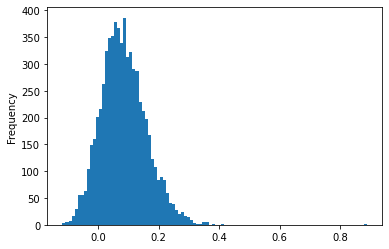

In [52]:
df['score'].plot(kind='hist', bins=100)

In [53]:
#low score sentence trend to get bad translation
df[(df['score'])<0.3].sample(5)

,input,news headline,score
2911,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ข่าวปลอม อย่าแชร์! วัคซีนทางเลือกต้องจ่ายแพงกว...,0.154500
4923,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ชัวร์ก่อนแชร์ : แป้งพัฟทำให้หน้าแก่ จริงหรือ ?,0.104448
888,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok","ปิดโรงงาน จิวเวลรี่ดัง คนตกงานกว่า 2,600 คน",0.025376
1582,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ผลออกแล้ว! กลุ่มเสี่ยงกว่า 1.6พันคน สัมผัสทหาร...,0.137286
1756,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok",ข่าวปลอม! พม. เปิดให้ลงทะเบียนเยียวยากลุ่มเปรา...,0.190508


In [55]:
#high score sentence trend to get good translation
df[(df['score'])>0.8].sample(1)

,input,news headline,score
15,"เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok","เพจดังเตือนระวัง ""กาแฟผสมยาอี"" ฮิตใน Tiktok ป...",0.888546
